In [1]:
%load_ext autoreload
%autoreload 2

## Imports

### Libraries

In [31]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
from torch.optim import lr_scheduler
from torch import optim
import copy
from datetime import time
import wandb

### Custom

In [42]:
from cv_geoguessr.grid.grid_partitioning import Partitioning
from cv_geoguessr.utils.plot_images import plot_images
from cv_geoguessr.utils.evaluation import create_confusion_matrix
from cv_geoguessr.data.data_loader import get_data_loader
from cv_geoguessr.data.data_loader import preview_images
from cv_geoguessr.network.training import train_model
from cv_geoguessr.network.model import load_model


## Colab specific

Run only when using Colab.

In [4]:
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

## Logging in via WandB

In [5]:
wandb.init(project="CV-GeoGuessr", entity="cv-geoguessr")

wandb: Currently logged in as: sjoerdgroot (cv-geoguessr). Use `wandb login --relogin` to force relogin


## Model constants

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225], device=device)

CITY_BOUNDS_FILE = '../data/metadata/city bounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'
GCLOUD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train" if train else "test"}/'

LONDON_PHOTO_DIR = GCLOUD_LONDON_PHOTO_DIR

SESSION = wandb.run.name
BASE_FOLDER = "./checkpoints"
CHECKPOINT_FOLDER = f'{BASE_FOLDER}/{SESSION}/'

Device: cuda:0


In [40]:
config = {
    "train_batch_size": 32,
    "test_batch_size": 100,
    "cell_width": 0.01,
    "voronoi": True,
    "lr": 0.001,
    "momentum": 0.9,
    "gamma": 0.1,
    "lr_decay_step": 7,
    "epochs": 50,
    "lock_factor": 0.8 # How much of the layers are locked 1 for every thing 0 for training the whole model
}

wandb.config.update(config)

### ImageNet setup

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt


## Download ResNet50

In [7]:
resnet50 = models.resnet50(pretrained=True, progress=True)
resnet50.to(device)

print('Downloaded ResNet50')

Downloaded ResNet50


In [32]:
summary(resnet50, (3, 224, 224))

## Load the data

### Set up grid partitioning

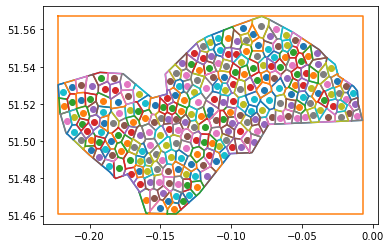

In [37]:
grid_partitioning = Partitioning(CITY_BOUNDS_FILE,
                                 cell_width=config["cell_width"],
                                 voronoi=config["voronoi"])
grid_partitioning.plot()

number_of_grid_elements = len(grid_partitioning.cells)
wandb.config.update({"number_of_grid_elements": number_of_grid_elements})

### Create the data loaders

In [22]:
data_loaders, data_set_sizes = get_data_loader(LONDON_PHOTO_DIR, grid_partitioning,
                                               config["train_batch_size"],
                                               config["test_batch_size"],
                                               IMAGENET_MEAN,
                                               IMAGENET_STD)
print(data_set_sizes)

{'train': 10038, 'val': 2000}


### Preview some training images

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


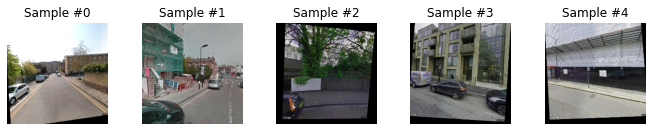

In [29]:
eval_images, eval_coordinates = preview_images(data_loaders["train"], SAMPLES_TO_SHOW, IMAGENET_MEAN, IMAGENET_STD, device)


## Train on the grid output

### Defining network criterion, optimizer and lr

In [38]:
for param in resnet50.parameters():
    param.requires_grad = False

resnet50.fc = nn.Linear(resnet50.fc.in_features, number_of_grid_elements)
resnet50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# We might not want this for the initial few epochs I (sjoerd) think but lets just roll with it
optimizer_ft = optim.SGD(resnet50.fc.parameters(), lr=config["lr"], momentum=config["momentum"])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=config["lr_decay_step"], gamma=config["gamma"])

In [ ]:
### Save the first untrained checkpoint

In [39]:
import os

if not os.path.isdir(CHECKPOINT_FOLDER):
    os.makedirs(CHECKPOINT_FOLDER)

torch.save(resnet50.state_dict(), CHECKPOINT_FOLDER + "0.ckpt")

In [46]:
from cv_geoguessr.network.model import lock_layers

resnet50 = lock_layers(resnet50, (3, 224, 224), config["lock_factor"])

255/317 params locked


In [ ]:
# Lets train the model for the first time
resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, data_loaders,
                       data_set_sizes, grid_partitioning, CHECKPOINT_FOLDER, device, num_epochs=25)


Epoch 0/24
----------


In [43]:
# only works if the loaded model has the same output as the current model
MODEL_TO_LOAD_PATH = BASE_FOLDER + "/second_test/epoch_24.ckpt"
resnet50 = load_model(resnet50, MODEL_TO_LOAD_PATH, config["lock_factor"], device)

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([16, 2048]) from checkpoint, the shape in current model is torch.Size([252, 2048]).
	size mismatch for fc.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([252]).

In [ ]:
# now train with the loaded model with more layers unlocked

optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


In [ ]:
confusion_matrix = create_confusion_matrix(resnet50, grid_partitioning, data_loaders['val'], False, device)
print(confusion_matrix.to('cpu'))

In [ ]:
from cv_geoguessr.utils.plot_results import plot_confusion_matrix

plot_confusion_matrix(confusion_matrix)